# Compare SEMITONES cell selection across selected methods
In this notebook we compare SEMITONES cell selection to several alternative methods.

## 1. Set up the notebook

### a. Load packages

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

from collections import Counter
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import directed_hausdorff
from SEMITONES.cell_selection import from_knn_dist
from SEMITONES.tfidf import TFIDF
from SEMITONES.support_funcs import load_sparse_h5
from sklearn.decomposition import TruncatedSVD

### b. Define scoring functions

In [2]:
def get_counts(metadata, key, indices):

    """Given the metadata, compute how many of the cell types are
    selected."""

    n_dict = Counter(metadata.iloc[indices, :].loc[:, key])
    counts = pd.concat([metadata.groupby(key).count().iloc[:, 0],
                        pd.DataFrame(n_dict, index=["n_selected"]).T],
                       axis=1).fillna(0)
    counts.columns = ["N", "n"]
    
    return counts

### c. Load the metadata for evaluation
Obtained from the Granja et al. publication.

In [3]:
meta = pd.read_csv("../data/external/greenleaf_scRNA_cell_metadata.txt",
                   sep="\t")
# get the cell order as it is in the count matrix
order = pd.read_csv(
    "../data/processed/greenleaf_scRNA_combined_filtered_barcodes.txt",
    header=None).values.ravel()  # from the processed data
meta.index = meta["Group"] + ":" + meta["Barcode"]  #compatible
meta = meta.loc[order, :]  # order according to processed data
ntypes = np.unique(meta.BioClassification).shape[0]  # number of cell types

## 2. Evaluate the proportion of cell types selected across parameter sets

### a. Get the files

In [4]:
rfiles = [
    "SEMITONES_umap35.pkl",
    "SEMITONES_umap10.pkl",
    "SEMITONES_umap50.pkl",
    "SEMITONES_counts.pkl",
    "SEMITONES_tfidf.pkl",
    "SEMITONES_svd30.pkl",
    "SEMITONES_svd10.pkl",
    "SEMITONES_svd100.pkl",
    "SEMITONES_umap5.pkl",
    "SEMITONES_svd50.pkl",
    "SEMITONES_umap25.pkl",
    "SEMITONES_svd70.pkl"
]

### b. Compute the proportion of cell types selected

In [5]:
P = {}
for r in rfiles:
    with open(f"{r}", "rb") as f:
        rdict = pickle.load(f)
    f.close()
    exp = r.split("_")[1].split(".")[0]
    
    P[exp] = {}
    for m, d in rdict.items():
        for n, i in d.items():
            c = get_counts(meta, "BioClassification", indices=i)["n"]
            p = np.count_nonzero(c) / ntypes
            P[exp][f"{m}_{n}"] = p
            del c, p
P_df_SEMITONES = pd.DataFrame(P)
P_df_SEMITONES  # check out the dataframe

,umap35,umap10,umap50,counts,tfidf,svd30,svd10,svd100,umap5,svd50,umap25,svd70
cosine_36,0.615385,0.615385,0.615385,0.500000,0.730769,0.730769,0.769231,0.807692,0.615385,0.807692,0.615385,0.807692
cosine_75,0.846154,0.807692,0.807692,0.769231,0.884615,0.884615,0.884615,0.923077,0.884615,0.923077,0.884615,0.961538
cosine_176,0.961538,0.961538,0.923077,0.846154,0.961538,1.000000,0.961538,0.961538,1.000000,1.000000,0.961538,1.000000
cosine_352,0.961538,1.000000,0.961538,0.884615,0.961538,1.000000,0.961538,1.000000,1.000000,1.000000,0.961538,1.000000
rbf_36,0.730769,0.730769,0.692308,0.576923,0.653846,0.846154,0.807692,0.769231,0.769231,0.807692,0.692308,0.769231
rbf_75,0.923077,0.923077,0.846154,0.769231,0.769231,0.961538,0.923077,0.884615,0.923077,1.000000,0.923077,0.923077
rbf_176,1.000000,1.000000,1.000000,0.923077,0.846154,1.000000,0.961538,1.000000,0.961538,1.000000,1.000000,1.000000
rbf_352,1.000000,1.000000,1.000000,0.884615,0.923077,1.000000,1.000000,1.000000,0.961538,1.000000,1.000000,1.000000
euclidean_36,0.769231,0.769231,0.769231,0.538462,0.653846,0.846154,0.807692,0.769231,0.846154,0.807692,0.769231,0.769231
euclidean_75,0.846154,0.884615,0.846154,0.769231,0.769231,0.961538,0.923077,0.884615,0.884615,1.000000,0.884615,0.923077


### c. Plot the results as a heatmap

#### i. Organize labels

In [6]:
# order the columns
order = ["tfidf",
         "svd10", "svd30", "svd50", "svd70", "svd100",
         "umap5", "umap10", "umap25", "umap35", "umap50"]
# corresponding labels
xlabels = ["tf-idf",
           "10D SVD", "30D SVD", "50D SVD", "70D SVD", "100D SVD",
           "5D UMAP", "10D UMAP", "25D UMAP", "35D UMAP", "50D UMAP"]
# N cells selected axis
ncells = [int(i.split("_")[1]) for i in P_df_SEMITONES.index]
ncells = [round(i / meta.shape[0], 3) * 100 for i in ncells]
metrics = [i.split("_")[0] for i in P_df_SEMITONES.index]
metrics = [i.title() if not i == "rbf" else "RBF" for i in metrics]

# order the dataframe
P_df_SEMITONES = P_df_SEMITONES.loc[:, order]

#### ii. Plot the heatmap

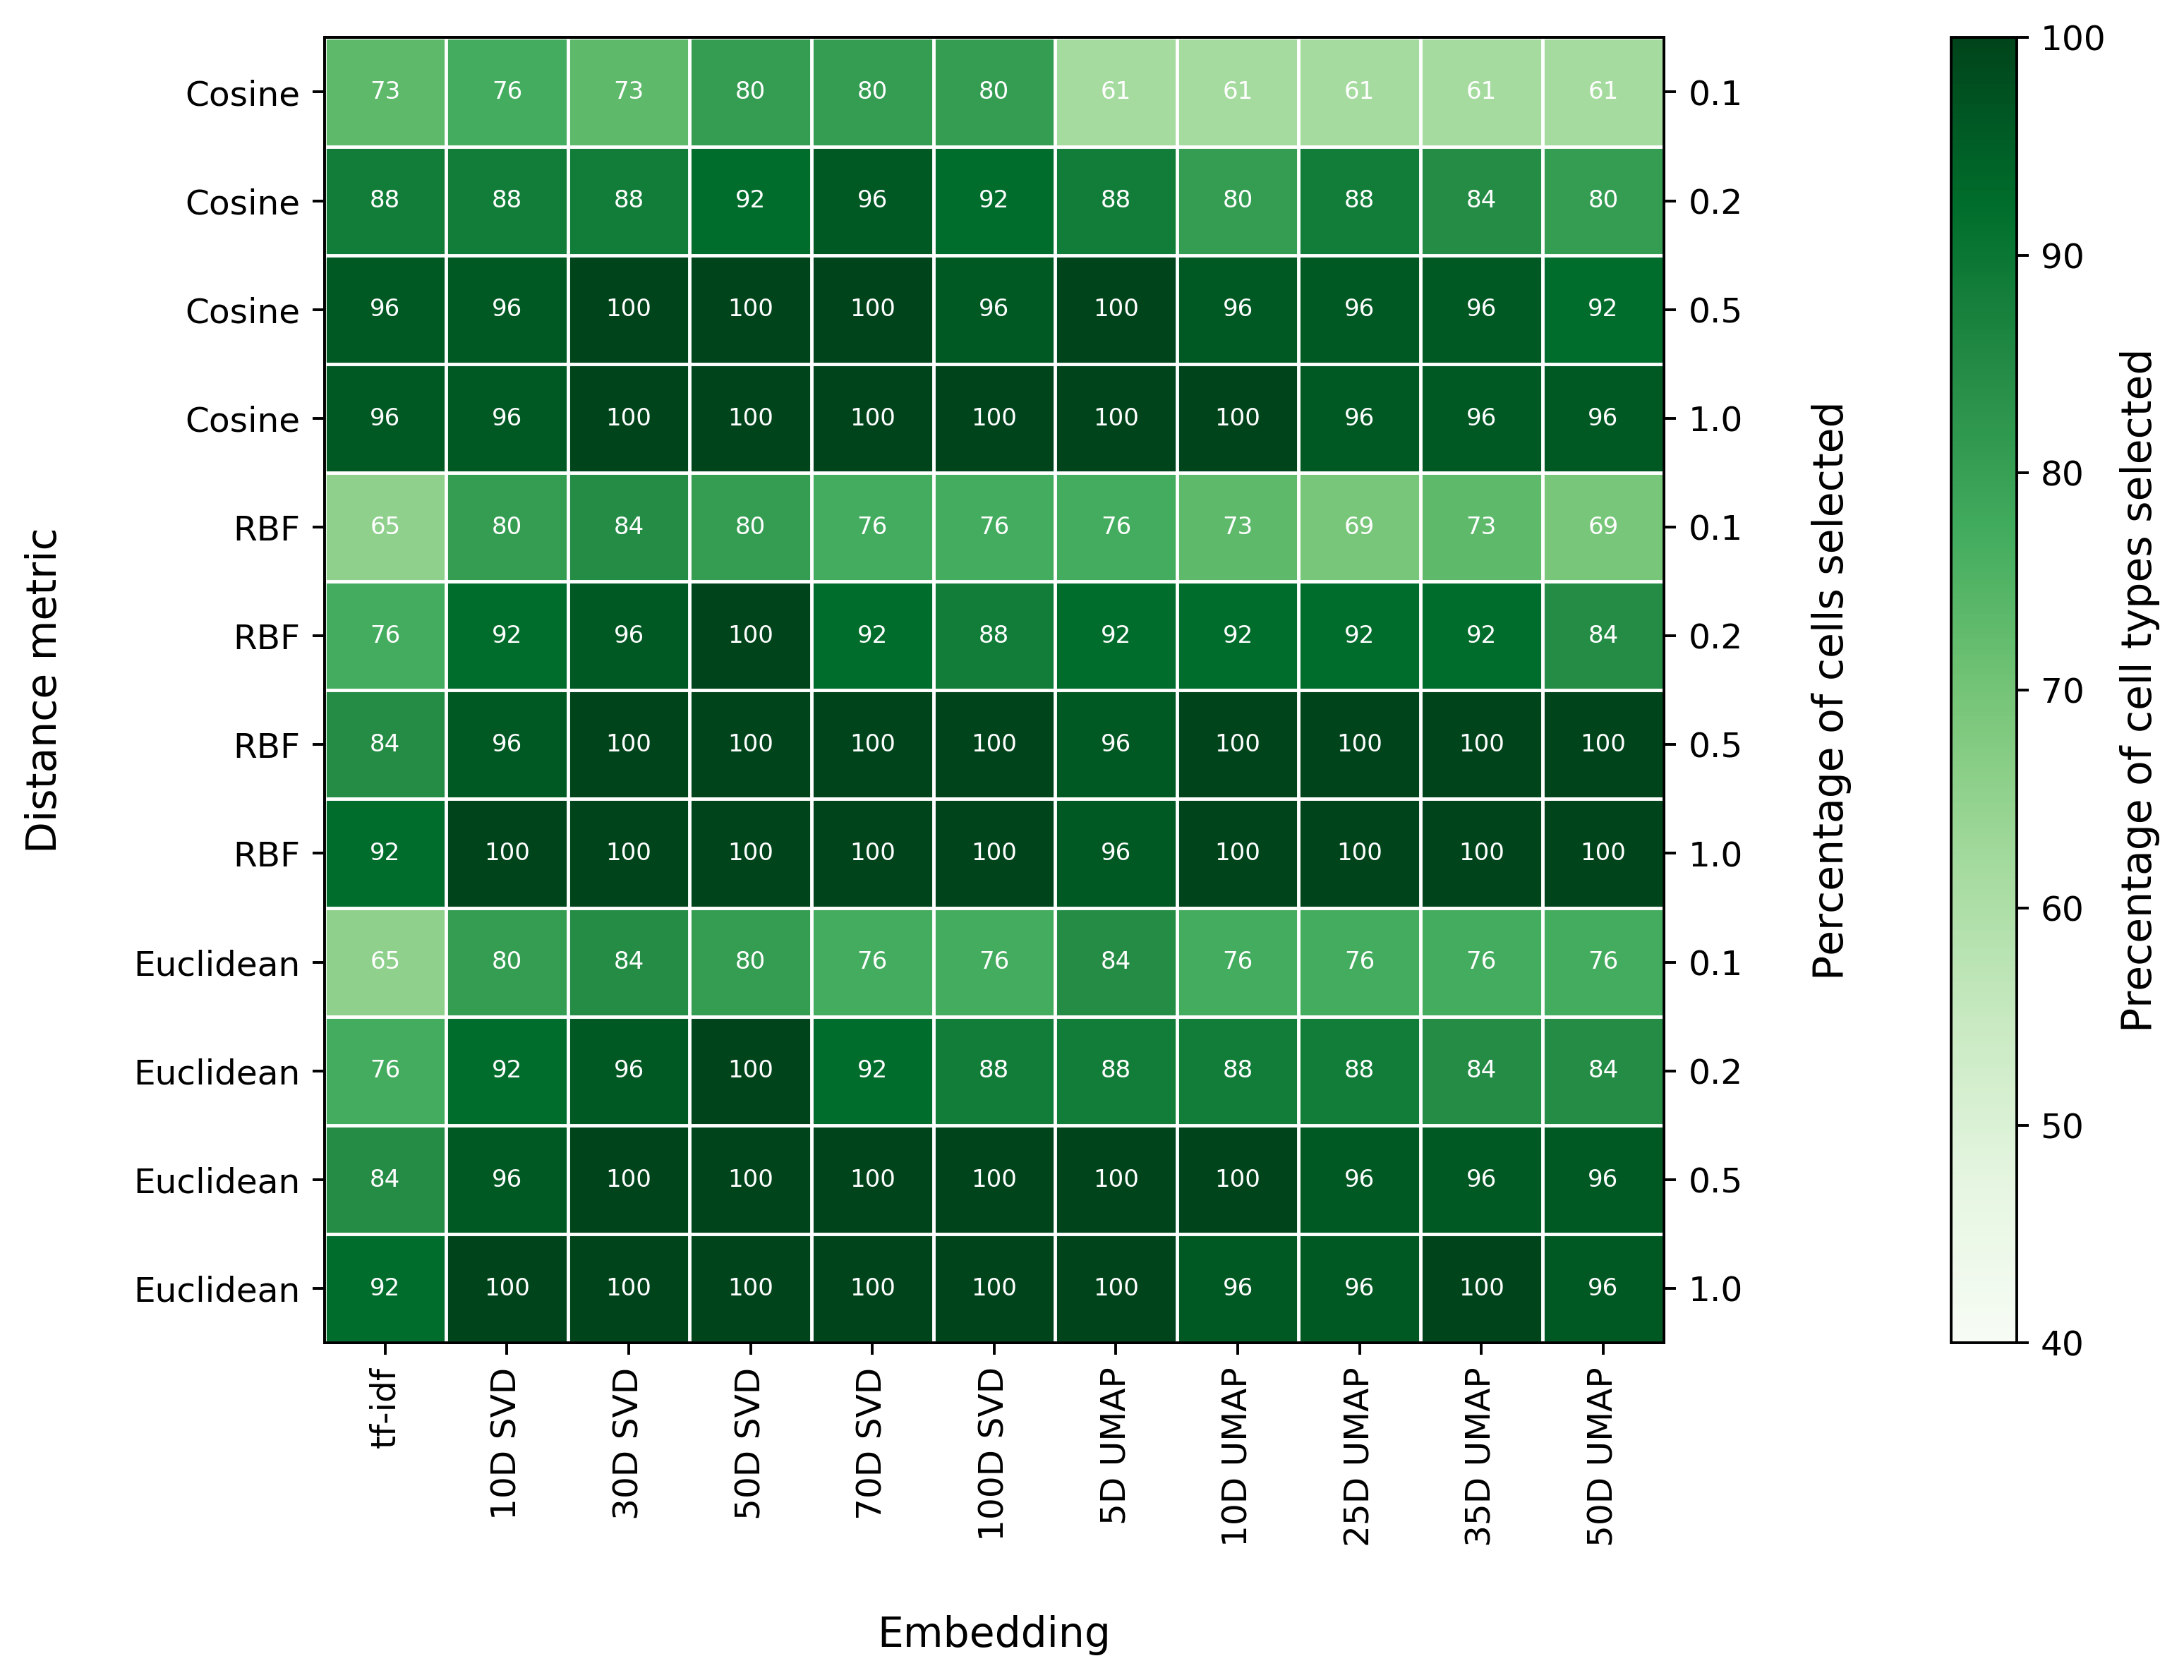

In [7]:
# plot figure
plt.figure(figsize=(10, 7), dpi=350)
plt.imshow(P_df_SEMITONES.values * 100, vmin=40, vmax=100, cmap="Greens",
           aspect="auto")
cbar = plt.colorbar(pad=.15)
cbar.ax.set_ylabel("Precentage of cell types selected", fontsize=12)
ax = plt.gca()

# make up the axes
nrows, ncols = P_df_SEMITONES.shape

# x-axis
ax.set_xticks(range(ncols))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_xlabel("Embedding", labelpad=20, fontsize=12)

# y-axis
ax.set_yticks(range(nrows))
ax.set_yticklabels(metrics)
ax.set_ylabel("Distance metric", labelpad=20, fontsize=12)

# second y-axis
tickax = plt.gca().twinx()
tickax.imshow(P_df_SEMITONES.values * 100, vmin=50, vmax=100, cmap="Greens",
              aspect="auto", zorder=-1)
tickax.set_yticks(range(nrows))
tickax.set_yticklabels(ncells)
tickax.set_ylabel("Percentage of cells selected", labelpad=20, fontsize=12)

# create text annotations
for i in range(nrows):
    for j in range(ncols):
        text = ax.text(j, i, int(P_df_SEMITONES.iloc[i, j] * 100),
                       ha="center", va="center", color="w",
                       fontsize=7)
tickax.set_zorder(tickax.get_zorder()-1)

# adjust ticks and create lines
ax.set_xticks(np.arange(ncols+1)-.5, minor=True)
ax.set_yticks(np.arange(nrows+1)-.5, minor=True)
ax.grid(b=True, which="minor", axis="both", color="white", linestyle="-",
        linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

## 3. Evaluate the proportion of cell types selected across methods

### a. Get the files

In [8]:
# rfiles = [
#      "cell_selection_fps_random_init_umap25.pkl",
#      "cell_selection_fps_smart_init_svd50.pkl",
#      "cell_selection_geosketch_default.pkl",
#      "cell_selection_semitones_umap25_random_init.pkl",
#      "cell_selection_milo_d50_k10.pkl",
#      "cell_selection_geosketch_k10000.pkl",
#      "cell_selection_fps_random_init_svd50.pkl",
#      "cell_selection_semitones_svd50_smart_init.pkl",
#      "cell_selection_random_sampling.pkl",
#      "cell_selection_semitones_svd50_random_init.pkl",
#      "cell_selection_semitones_umap25_smart_init.pkl",
#      "cell_selection_fps_smart_init_umap25.pkl"
# ]
rfiles = [f for f in rfiles if (f.startswith("20211001") or f.startswith("20211004"))]

### b. Compute the proportion of cell types selected

In [9]:
P = {}
for r in rfiles:
    # load the selected indices
    with open(f"{r}", "rb") as f:
        cell_list = pickle.load(f)
    f.close()
    
    # extract method name
    exp = r.split("_")
    exp = "_".join(exp[4:len(exp)])
    exp = exp.split(".")
    exp = "_".join(exp[0:len(exp) - 1])

    # get the percentage of cell types that are selected
    P[exp] = {}
    if isinstance(cell_list[0], np.int64):  # if only one iteration
        c = get_counts(meta, "BioClassification", indices=cell_list)["n"]
        p = np.count_nonzero(c) / ntypes
        P[exp][0] = p
        del c, p
    else:              
        for i, cells in enumerate(cell_list):  # for each iteration
            c = get_counts(meta, "BioClassification", indices=cells)["n"]
            p = np.count_nonzero(c) / ntypes
            P[exp][i] = p
            del c, p
P_df_methods = pd.DataFrame(P)
P_df_methods

,fps_random_init_umap25,fps_smart_init_svd50,geosketch_default,semitones_umap25_random_init,milo_d50_k10,geosketch_k10000,fps_random_init_svd50,semitones_svd50_smart_init,random_sampling,semitones_svd50_random_init,semitones_umap25_smart_init,fps_smart_init_umap25
0,0.923077,0.769231,0.500000,0.884615,0.730769,0.769231,0.730769,1.0,0.692308,0.961538,0.923077,0.923077
1,1.000000,NaN,0.576923,0.884615,0.692308,0.653846,0.769231,NaN,0.769231,1.000000,NaN,NaN
2,0.923077,NaN,0.500000,1.000000,0.807692,0.538462,0.730769,NaN,0.730769,0.961538,NaN,NaN
3,0.923077,NaN,0.576923,0.961538,0.730769,0.692308,0.730769,NaN,0.730769,0.884615,NaN,NaN
4,0.961538,NaN,0.423077,0.923077,0.884615,0.730769,0.730769,NaN,0.692308,0.884615,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.961538,NaN,0.461538,0.923077,0.730769,0.769231,0.730769,NaN,0.653846,0.961538,NaN,NaN
96,1.000000,NaN,0.500000,0.923077,0.730769,0.653846,0.769231,NaN,0.846154,1.000000,NaN,NaN
97,0.923077,NaN,0.500000,0.923077,0.769231,0.692308,0.769231,NaN,0.769231,0.961538,NaN,NaN
98,1.000000,NaN,0.500000,0.923077,0.692308,0.692308,0.769231,NaN,0.730769,1.000000,NaN,NaN


### c. Plot the selected cell type propotion as a violin plot

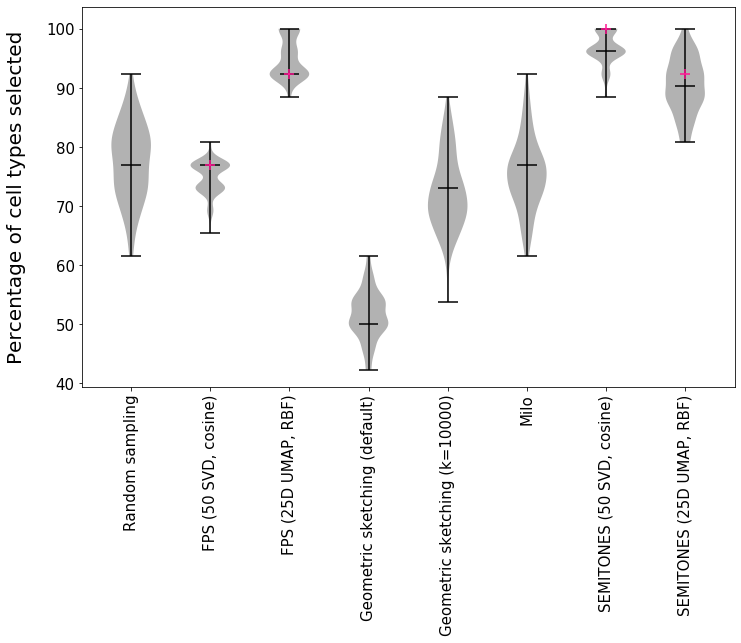

In [10]:
order = ["random_sampling",
         "fps_random_init_svd50", "fps_random_init_umap25",
         "geosketch_default", "geosketch_k10000",
         "milo_d50_k10",
         "semitones_svd50_random_init", "semitones_umap25_random_init"]
vdata = P_df_methods[order].T
exps = ["Random sampling",
        "FPS (50 SVD, cosine)", "FPS (25D UMAP, RBF)",
        "Geometric sketching (default)", "Geometric sketching (k=10000)",
        "Milo",
        "SEMITONES (50 SVD, cosine)", "SEMITONES (25D UMAP, RBF)"]

plt.figure(figsize=(11.7, 7))
v = plt.violinplot(vdata * 100, showmedians=True)  # violinplot
# make-up labels
for p in v["bodies"]:
    p.set_facecolor("black")
for p in ["cbars", "cmins", "cmaxes", "cmedians"]:
    v[p].set_edgecolor("black")
plt.xticks(range(1, 9), exps, rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Percentage of cell types selected", fontsize=20, labelpad=20)

xs = [2, 3, 7, 8]  # location for smart init
# methods
ylabels = ["fps_smart_init_svd50", "fps_smart_init_umap25",
           "semitones_svd50_smart_init", "semitones_umap25_smart_init"]
# get values
ys = [P_df_methods.loc[:, i][0] * 100 for i in ylabels]
# plot values as scatter on top of Violin
plt.scatter(xs, ys, marker="+", s=100, color="deeppink", zorder=2)